In [286]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [287]:
# Class to store each tag coordinate data
class tagClass:
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip(8)
        self.tagClass = tClass
    
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    def getSnip(self, n=20):
        newX = self.x-(n/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(n/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+n), int(newY), int(newY+n)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [288]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [289]:
def getTags(rawData, nType):
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

In [290]:
trainTags = getTags(raw15['0'], ['649', '655', '657', '659', '661'])
testTags = getTags(raw15['0'], ['669', '671'])

In [291]:
bayerFilter = [["R", "G"],
               ["G", "B"]]

In [292]:
# Find Bayer filter pixel colour for given coordinate
def getBayer(x, y):
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR

In [293]:
def getTags(l):
    for i in range(20):
        # tagX, tagX2, tagY, tagY2 =
        print(l[i].getTagCoords())
    # photo[tagX:tagX2][tagY:tagY2]

In [294]:
def getSnipPlot(tag):
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    # plt.imshow(photo[tagY:tagY2,tagX:tagX2],cmap='gray')
    # plt.colorbar()
    # rect = patches.Rectangle((tag.getY()-tagY-4.5, tag.getX()-tagX-4.5), 9, 9, linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(rect)
    # plt.show()

    return photo

In [295]:
def getPixels(tag, photo):
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    colourPixels = [[], [], []] # R G B
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                colourPixels[0].append(photo[py, px])
            elif col == 'G':
                colourPixels[1].append(photo[py, px])
            else:
                colourPixels[2].append(photo[py, px])
    totalSum = sum(colourPixels[0]) + sum(colourPixels[1]) + sum(colourPixels[2])
    return sum(colourPixels[0])/totalSum, sum(colourPixels[1])/totalSum, sum(colourPixels[2])/totalSum

In [296]:
xTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue"])
for tag in trainTags:
    photo = getSnipPlot(tag)
    redVal, greenVal, blueVal = getPixels(tag, photo)
    xTags.loc[len(xTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal]

xTrain, xTest, yTrain, yTest = train_test_split(xTags[["Red", "Green", "Blue"]], xTags["Label"], test_size=0.2)

In [297]:
yTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue"])
for tag in testTags:
    photo = getSnipPlot(tag)
    redVal, greenVal, blueVal = getPixels(tag, photo)
    yTags.loc[len(yTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal]

In [298]:
import ternary

def colorPoint(x, y, z, scale):
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 1.)

def generateHeatmapData(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = colorPoint(i, j, k, scale)
    return d

def plotHeatmap(asTuples, labels, scale):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)#np.array(expected['002']))
    tax._redraw_labels()
    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    for a, b in zip(labels, asTuples):
        tax.annotate(int(a), b, color='white')
    plt.show()

In [299]:
def plotHeatmapDifferent(asTuples, labels, scale, mark):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    for a, b in zip(labels, asTuples):
        m = mark[int(a)]
        tax.scatter(b*scale, marker=m, color='#fff', label=a, zorder=3)
        tax.annotate(int(a), b, color='white')
    # tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)#np.array(expected['002']))
    tax._redraw_labels()
    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    
    plt.show()

c:\Users\katie\AppData\Local\Programs\Python\Python311\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


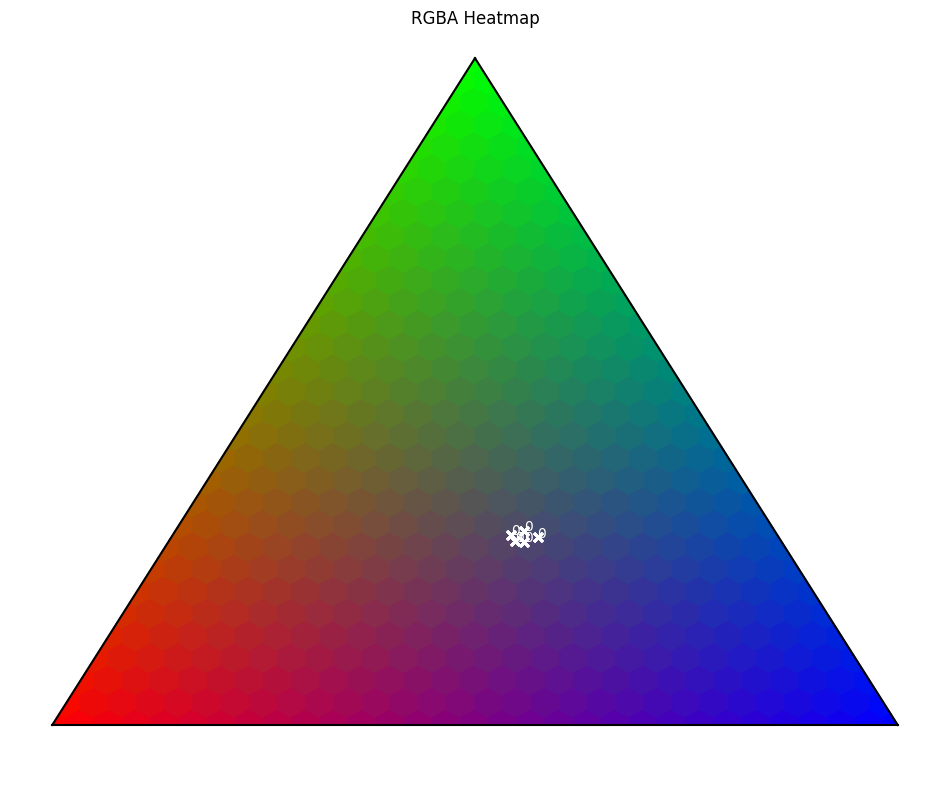

In [300]:
scale = 30
tagList = [0]
sampleTags = xTags.loc[xTags["Label"].isin(tagList)]
asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in sampleTags.iterrows()]
labels = sampleTags["Label"]
markers = [".", "o", "^", "s", "*"]
plotHeatmap(asTuples, labels, scale)
# plotHeatmapDifferent(asTuples, labels, scale, markers)

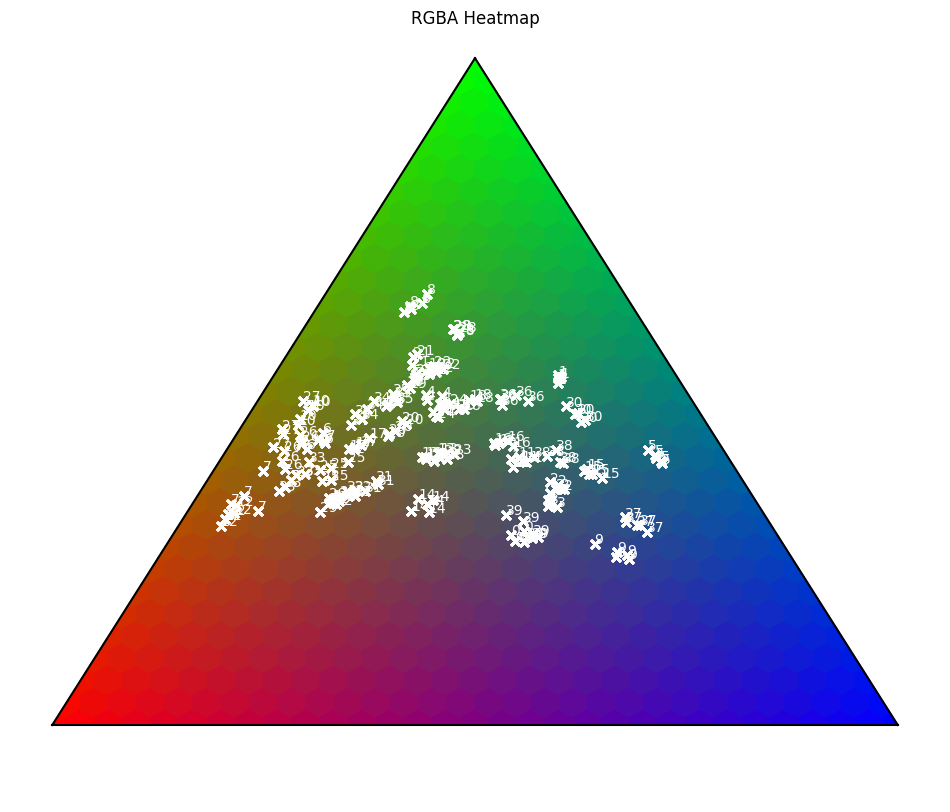

In [301]:
asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in xTags.iterrows()]
labels = xTags["Label"]
plotHeatmap(asTuples, labels, scale)

In [302]:
gnb = GaussianNB().fit(xTrain, yTrain)
gnbPred = gnb.predict(yTags[["Red", "Green", "Blue"]])

In [303]:
clf = svm.SVC().fit(xTrain, yTrain)
svmPred = clf.predict(yTags[["Red", "Green", "Blue"]])

In [304]:
# mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1).fit(xTrain, yTrain)
# mlpPred = mlp.predict(yTags[["Red", "Green"]])

In [305]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, name):
    print(name)
    print("Accuracy: ", accuracy_score(yTags["Label"], modelPred))
    print("F1: ", f1_score(yTags["Label"], modelPred, average='macro'))
    print("Precision: ", precision_score(yTags["Label"], modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(yTags["Label"], modelPred, average='macro'))
    print("MSE: ", mean_squared_error(yTags["Label"], modelPred), "\n")

In [306]:
scores(gnbPred, "GNB")
scores(svmPred, "SVM")
# scores(mlpPred, "MLP")

GNB
Accuracy:  0.6375
F1:  0.6044047619047619
Precision:  0.7198198198198198
Recall:  0.6375
MSE:  135.8625 

SVM
Accuracy:  0.4125
F1:  0.2976923076923077
Precision:  0.5269480519480518
Recall:  0.4125
MSE:  215.1125 



In [ ]:
# average colours from all images - normalise
# R/(R+G+B) G/(R+G+B)
# train model on colours & labels
# test model to classfiy other image labels

# maybe remove background mesh
# func pixel coords generated to show brightness
# psf tagxy brightness pf col, bg of col, pixel ->> pred cixel col -> SSE
# brightness for each col -> then loop all pixels then predict pixels -> SSE = func - true picel val

In [ ]:
# run with smaller box around pixels - brightest as centre?
# bokeh out of focus width affected by distance?
# estimate brightness of bg?
# estimate width of brightest tags
# hexagonal bokeh - find centre of bokeh
# px, py, bi, hi, xi, yi per picture but width is same
# x y is centre of bokeh - tag coords
# 
# sum ( fn(px py xi yi hi w) - true px py ) ^2 ) for each pixel -> fn = guess pixel value
# sum that for all pictures - see notebook!!